**Autori:** \
Dávid Drobný \
Alexander Matuška \

**Podiel práce:** \
Dávid Drobný 50%\
Alexander Matuška 50%

# Fáza 2: Predspracovanie (max. 21b)

Na základe identifikovaných problémov v dátach a návrhu ich riešenia v predchádzajúcej fáze 
treba zrealizovať predspracovanie. Výsledkom by mala byť upravená dátová sada (vo formáte `csv`) 
vo vhodnom tvare pre strojové učenie. 
- To znamená, že jedno pozorovanie musí byť opísané jedným riadkom tabuľky; 
- V tretej fáze budeme pracovať s algoritmom(-ami), ktorého(ých) implementácia podporuje len numerické dáta, 
je možné že bude potrebné všetky nenumerické atribúty transformovať na numerické. 
- Keď sa predspracovaním mohol zmeniť tvar a charakteristiky dát (počet atribútov, distribúcie hodnôt a pod.), 
je možné že treba znovu zrealizovať podstatné časti prieskumnej analýzy a opakovane podľa Vašej potreby. 
- Významnú časť hodnotenia bude predstavovať znovupoužiteľnosť (replikovateľnosť) predspracovania.

> Správa sa odovzdáva v 9. týždni semestra na cvičení.
> Dvojica svojmu cvičiacemu odprezentuje vykonané predspracovanie v `Jupyter Notebooku`). 
> Následne správu elektronicky odovzdá jeden člen z  dvojice do systému AIS do **nedele 22.11.2020 23:59**.

In [1]:
import scipy
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer

In [2]:
# Loadneme jeden z CSV suborov
path_to_data = "../data/"
filename = path_to_data + "other_train.csv"
loaded_data = pd.read_csv(filename)

In [3]:
from os import listdir
print(listdir(path_to_data))

['other_train.csv', 'other_valid.csv', 'personal_train.csv', 'personal_valid.csv']


## Integrácia dát a prípadná deduplikácia záznamov (5b).

Výsledkom by mala byť jednotná tabuľková reprezentácia dát, ktorá bude predstavovať vstup 
pre ďalšie spracovanie a (v 3. fáze) strojové učenie.

Vyhodíme duplicitné záznamy pacientov s rovnakým menom a adresou. 

In [4]:
# vyhod duplicitne zaznamy
original_size = loaded_data.shape[0]

loaded_data.drop_duplicates(['name','address'], keep='first', inplace=True)

print(f'Droped { original_size - loaded_data.shape[0] } records')

Droped 50 records


Z predošlej analýzy vieme, že medical info skrýva v sebe asociatívne pole hodnôt, z ktorých môžeme vytvoriť nové parametre.

In [5]:
# Vytvorime nove atributy z medical_info
import json

def get_dict(input_string):
  # konvertuje string na dictionary
  input_string = input_string.replace("'", '"')
  valid_json_string = "[" + input_string + "]" 
  data = json.loads(valid_json_string)[0]
  # convert string values to float
  for i in data:
    data[i] = float(data[i])
  return data

# vytvori list asociativnych poli a prekonvertuje hodnoty na float
list_of_dictionaries = []
pocet_neuplnych = 0
for medical_info in loaded_data['medical_info']:
  # zdravotne informacie su kompletne
  if isinstance(medical_info, str):
    list_of_dictionaries.append(get_dict(medical_info))
  # ak chybaju
  else:
    pocet_neuplnych += 1

# konvertujeme list na DataFrame a pridavame ho do povodnych dat
list_of_dictionaries = pd.DataFrame(list_of_dictionaries)
loaded_data = pd.concat([loaded_data, list_of_dictionaries], axis=1, join='inner')

print('Pocet neuplnych:', pocet_neuplnych)

Pocet neuplnych: 5


Vytiahli sme z neho tieto nové parametre a zistili, koľko z nich obsahujú neúplné informácie. Nasledne vyhodíme stĺpec medical_info, kedže už máme jeho spracovanú verziu vo forme nových parametrov.

In [6]:
# Vyhodime medical_info
loaded_data.drop(columns='medical_info', inplace=True)

Taktiež vyhodíme stĺpec Unnamed, pretože obsahuje iba nadbytočné indexovanie dát

In [7]:
loaded_data.drop(loaded_data.filter(regex="Unnamed"),axis=1, inplace=True)

Taktiež z analýzy vieme, že atribúty "pregnant" a "workclass" reprezentujú jednu hodnotu viacerými

In [8]:
# Zjednotenie hodnot

loaded_data['pregnant'].replace('True', 1, inplace=True)
loaded_data['pregnant'].replace('TRUE', 1, inplace=True)
loaded_data['pregnant'].replace('T', 1, inplace=True)
loaded_data['pregnant'].replace('t', 1, inplace=True)

loaded_data['pregnant'].replace('False', 0, inplace=True)
loaded_data['pregnant'].replace('FALSE', 0, inplace=True)
loaded_data['pregnant'].replace('F', 0, inplace=True)
loaded_data['pregnant'].replace('f', 0, inplace=True)

loaded_data['pregnant'].unique()


array([ 0.,  1., nan])

In [9]:
# Upravime retazce tak, aby neobsahovali medzery a velke pismena
loaded_data['workclass'] = loaded_data['workclass'].str.strip().str.lower()

# nepoznane hodnoty upravime na nan
loaded_data['workclass'].replace('?', np.nan, inplace=True)

loaded_data['workclass'].unique()

array(['private', 'local-gov', 'self-emp-not-inc', 'state-gov', nan,
       'federal-gov', 'self-emp-inc', 'without-pay'], dtype=object)

Parameter income má len dve hodnoty vo forme stringu, takže to prehodíme na číselnú hodnotu.

In [10]:
# Zmenime atribut income na binarne hodnoty: 
# >50k - 1 (True)
# <=50k - 0 (False)

loaded_data['income'].replace(' >50K', 1, inplace=True)
loaded_data['income'].replace(' <=50K', 0, inplace=True)

loaded_data['income'].unique()

array([ 0.,  1., nan])

Chýbajúce hodnoty sme nechali v dátach pretože ich budeme riešiť v ďalšej časti


## Realizácia predspracovania dát a ich zdokumentovanie (6b). 
  - Pri riešení chýbajúcich hodnôt vyskúšajte rôzne stratégie (minimálne 1 stratégiu z 2 nasledujúcich podskupín):
    - nahradenie chýbajúcej hodnoty mediánom, priemerom alebo pomerom ku korelovanému atribútu
    - nahradenie chýbajúcej hodnoty priemerom segmentu, pomocou jednoduchej lineárnej regresie 
    	alebo k-najbližších susedov (kNN)
  - Podobne postupujte aj pri riešení vychýlených hodnôt (outlier): 
    - odstránenie vychýlených (odľahlých) pozorovaní
    - nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)
  - Transformácia atribútu/ov pomocou Power transform (logaritmus, odmocnina a pod.)



In [11]:
integrated_data = loaded_data.copy()
integrated_data.head()

,name,address,race,marital-status,occupation,pregnant,education-num,relationship,skewness_glucose,mean_glucose,...,std_glucose,income,native-country,hours-per-week,capital-loss,workclass,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
0,David Aaron,"866 Thomas Road Apt. 545\r\nNicholaschester, A...",White,Divorced,Craft-repair,0.0,900.0,Not-in-family,-0.271453,120.023438,...,49.763419,0.0,United-States,30.0,0.0,private,1.663880,11.912406,11.939385,197.057409
1,John Lopez,"8413 James Branch Suite 359\r\nEast Hannah, DC...",White,Divorced,Craft-repair,0.0,10.0,Not-in-family,0.969646,89.265625,...,43.097724,1.0,United-States,48.0,0.0,private,13.147993,41.482849,3.140735,8.691073
2,Joshua Hawley,Unit 6457 Box 7327\r\nDPO AP 20796,White,Never-married,Other-service,0.0,9.0,Unmarried,0.033778,120.296875,...,45.273537,0.0,United-States,35.0,0.0,private,3.924749,22.853709,7.383201,59.503396
3,Ben Little,7305 Patrick Plains Suite 945\r\nNorth Christi...,White,Never-married,Adm-clerical,0.0,14.0,Not-in-family,0.941634,115.226562,...,39.705402,0.0,United-States,56.0,0.0,private,3.100334,15.804987,7.847605,82.968316
4,Santos Pope,"94941 Hill Dam Suite 110\r\nWest Madison, LA 0...",White,Married-civ-spouse,Prof-specialty,0.0,9.0,Husband,-0.529270,118.171875,...,58.804776,1.0,United-States,55.0,0.0,private,2.930602,16.903950,8.011701,80.179046


Jednotlivé atribúty treba spracovať rozdielnými spôsobmi a preto sme ich rozdelili do 4 kategórií ("medical" je súčasťou "numerical")

In [12]:
# Rozdelene atributy podla typu hodnot
irrelevant = ['name', 'address']
medical = ['skewness_glucose','mean_glucose','kurtosis_glucose','std_glucose', 'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen']
numerical = ['education-num','capital-gain', 'fnlwgt','hours-per-week','capital-loss'] + medical
categories = ['race','marital-status','occupation','relationship','education','native-country','workclass']
booleans = ['pregnant','class','income']

Atribúty, ktoré nie sú podstatné pre učenie vyhodíme.

In [13]:
# vyhodit nepodstatne atributy pre cvicenie modelu
for attr in irrelevant:
  integrated_data.drop(columns=attr, inplace=True)

### Riešenie chýbajúcich hodnôt

Rozmýšlali sme ako riešiť chýbajúce hodnoty pri kategóriach a prvý nápad bol vyhodiť dané riadky, ale pokiaľ je takých hodnôt veľa, tak by to mohlo výrazne ovplyvniť naše dáta. Preto ak by množstvo vyhodených riadkov predstavovalo viac ako 1% z celku tak zvolíme inú stratégiu a dané riadky doplníme najfrekventovanejšou hodnotou.

In [14]:
print('Dropped from')
# iteruj cez nenumerickych atributy
for attr in categories + booleans:
  before = len(integrated_data[attr])
  after = len(integrated_data[integrated_data[attr].notna()])
  percentage = round(((before-after)/before)*100,5)  
  
  if percentage < 1:
    print(12*' ',attr, percentage, '%')
    # vyhod riadky s chybajucou hodnotou
    integrated_data = integrated_data[integrated_data[attr].notna()]
  else:
    # dopln chybajucu hodnotu
    print(12*' ',attr, percentage, "% (wasn't dropped)")
    integrated_data[attr].fillna(integrated_data[attr].mode()[0], inplace=True)

Dropped from
             race 0.20619 %
             marital-status 0.15496 %
             occupation 0.12933 %
             relationship 0.0777 %
             education 0.10368 %
             native-country 0.05189 %
             workclass 5.42575 % (wasn't dropped)
             pregnant 0.05192 %
             class 0.05195 %
             income 0.02599 %


In [15]:
# Definujeme si funkciu na zobrazenie grafov pre porovnanie metod
def show_graphs(numerical, data):
  for attr in numerical:
    data[attr].plot.hist(bins=100, title=attr)
    plt.show()

#### Náhrada numerických hodnôt priemerom

In [16]:
filling_numerical_mean = integrated_data.copy()

# nahradi chybajuce ciselne hodnoty priemerom
for attr in numerical:
  mean = filling_numerical_mean[attr].mean()
  filling_numerical_mean.fillna(mean, inplace=True)

#### Náhrada numerických hodnôt strednou hodnotou 

In [17]:
filling_numerical_quantile = integrated_data.copy()

# nahradi chybajuce ciselne hodnoty strednou hodnotou
for attr in numerical:
  q50 = filling_numerical_quantile[attr].quantile(0.50)
  filling_numerical_quantile.fillna(q50, inplace=True)

#### Náhrada numerických hodnôt lineárnou 

In [18]:
filling_numerical_linear = integrated_data.copy()

# nahradi chybajuce ciselne hodnoty strednou hodnotou
for attr in numerical:
  filling_numerical_linear[attr].interpolate(method='linear', inplace=True, limit_direction='both')

#### Porovanie metod nahradenia
Vyskúšali sme tri odlišné metódy, preto je nutné ich porovnať a tak zistiť, ktorá z nich je lepšia pre naše dáta.

In [19]:
# funkcia na porovnanie viacerych datovych setov 
def compare_graphs(data_list : list, data_attibutes : list):
  for attr in data_attibutes:
    fig, axes = plt.subplots(1, len(data_list), figsize=(20,7))
    for index, data in enumerate(data_list):
      data[attr].plot.hist(bins=100, title=attr, ax=axes[index])
    plt.show()

In [20]:
data_sets = [filling_numerical_mean, filling_numerical_quantile, filling_numerical_linear]

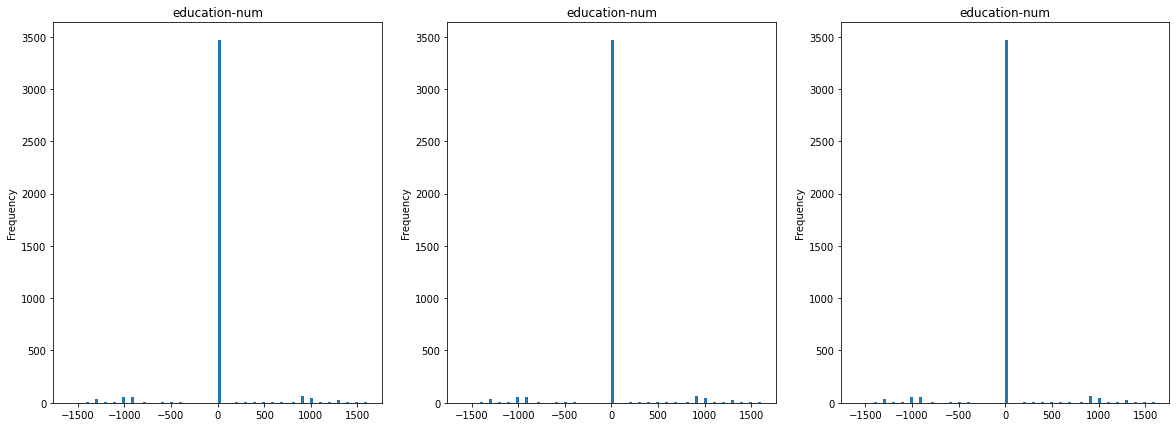

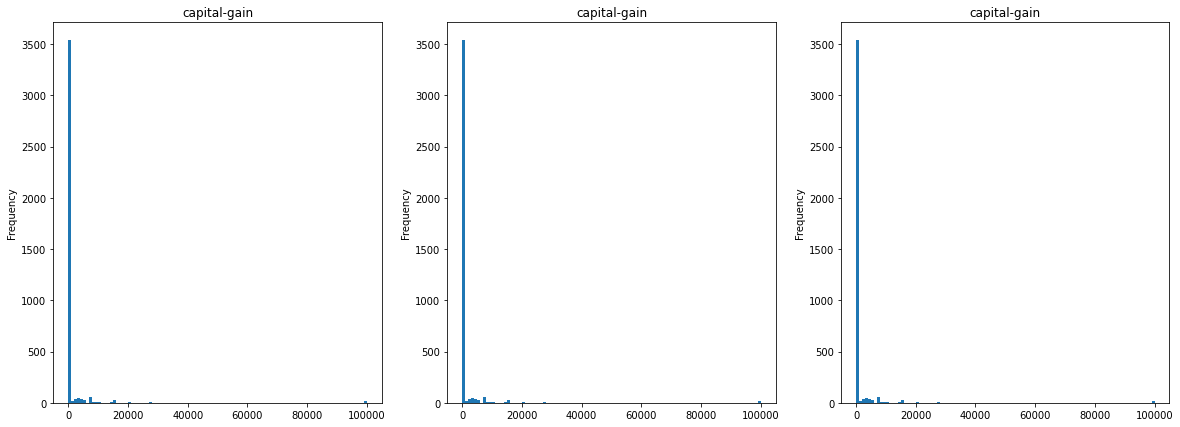

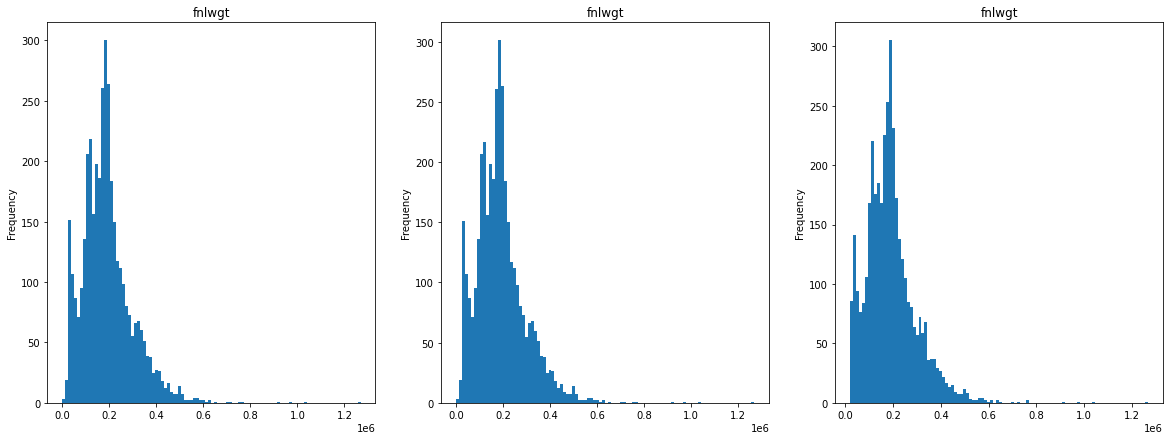

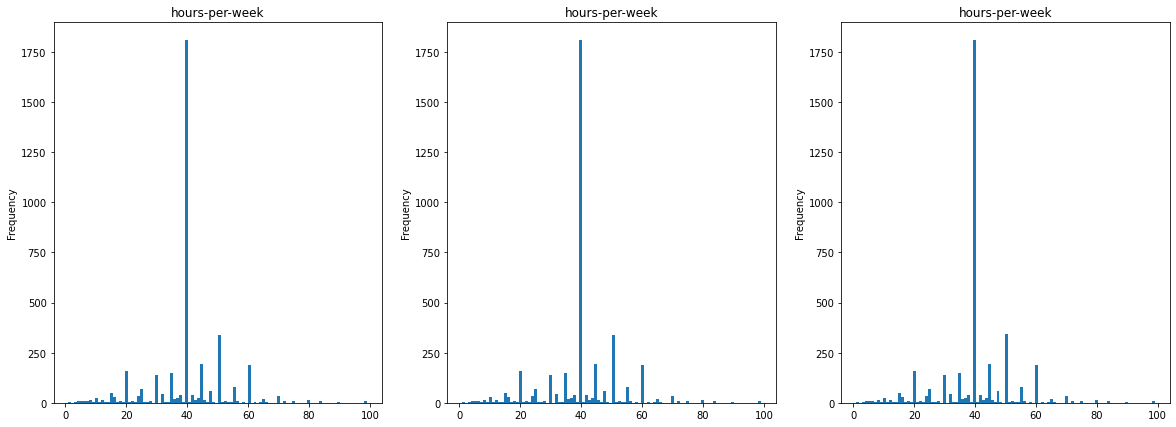

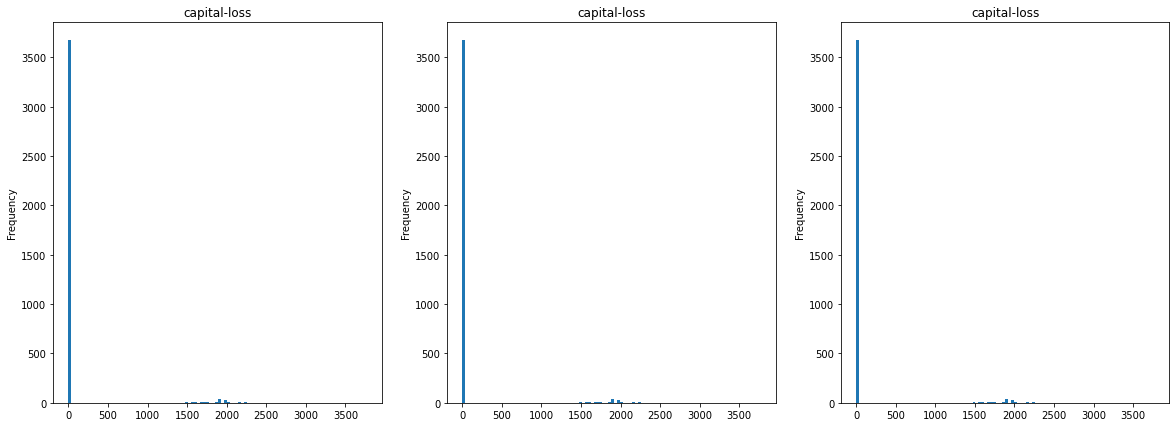

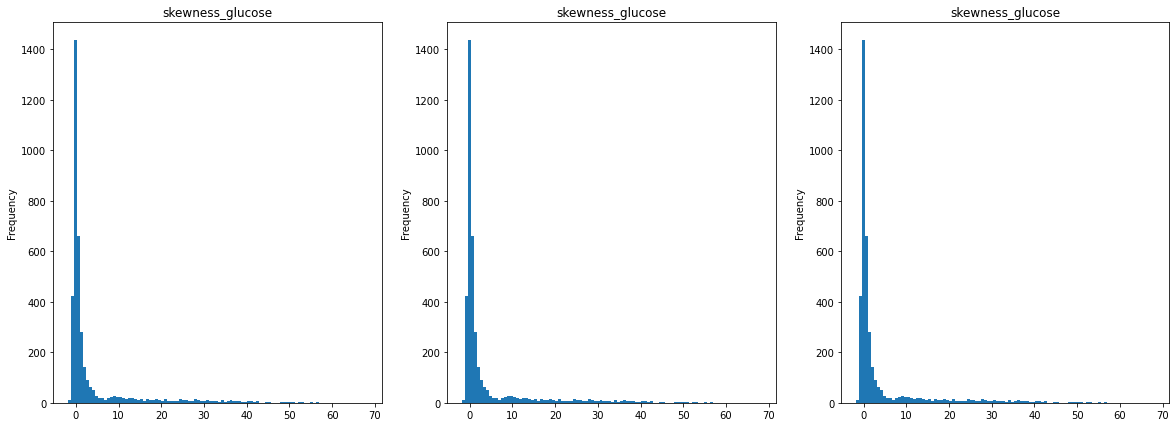

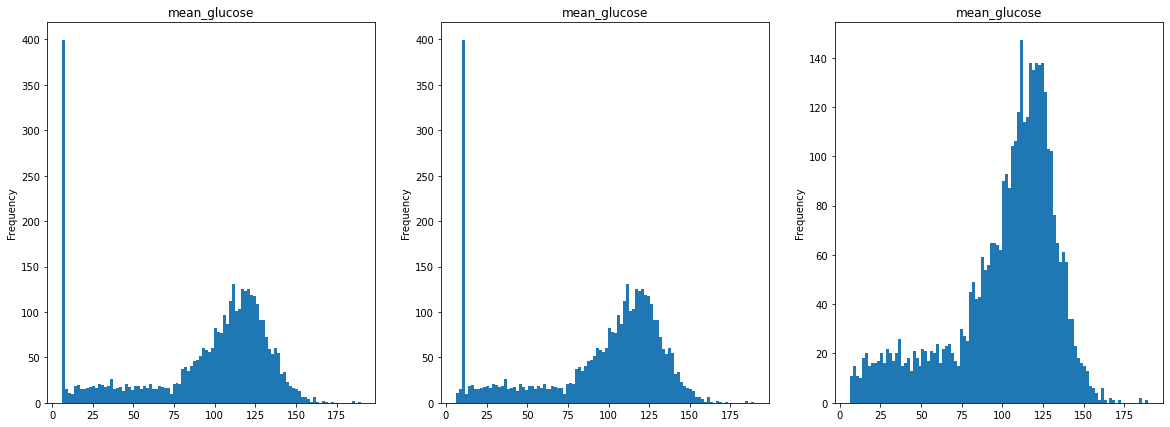

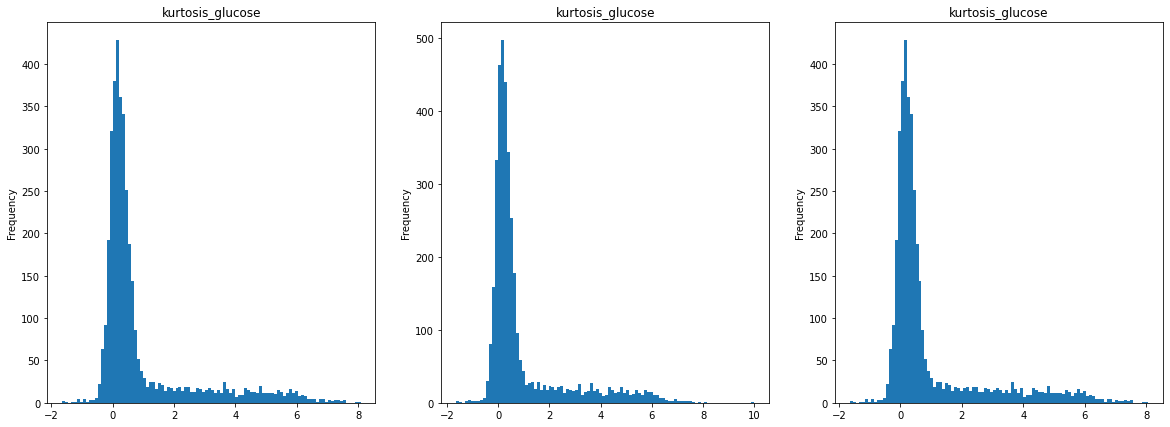

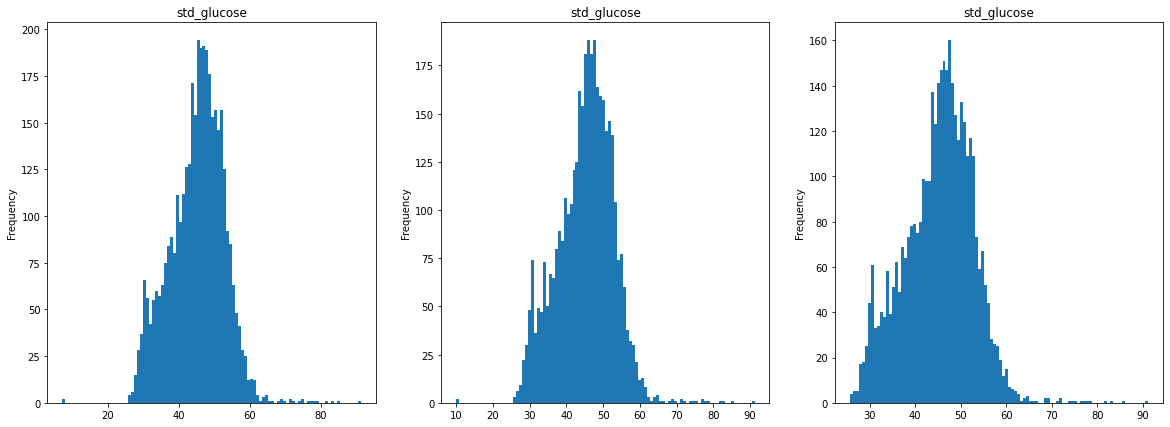

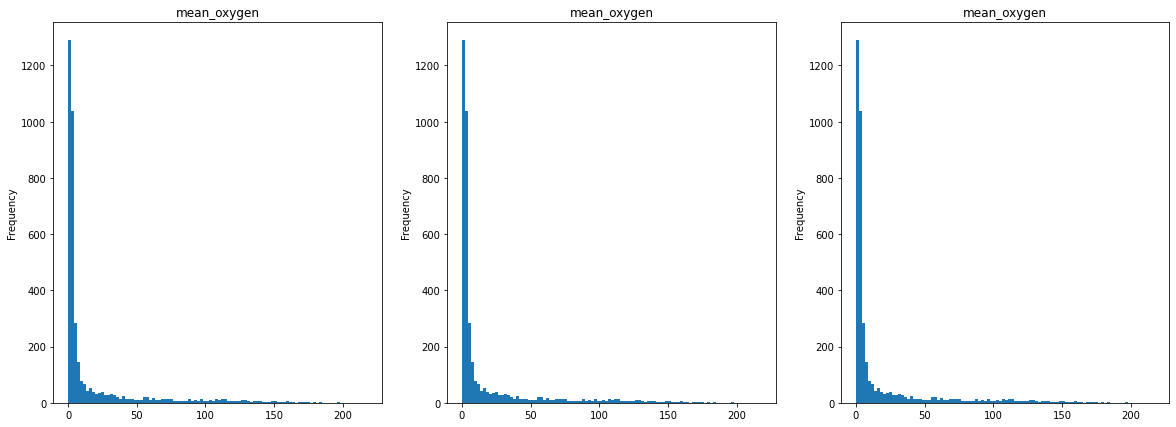

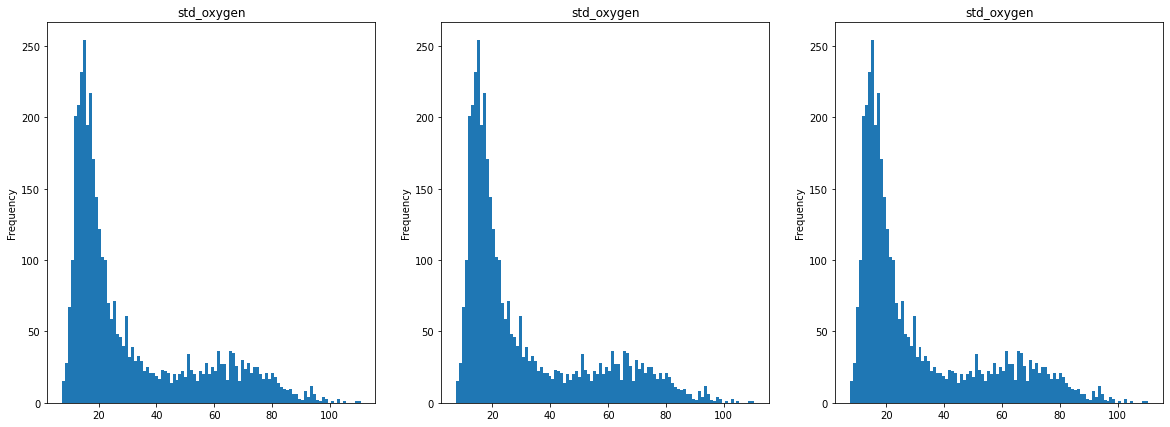

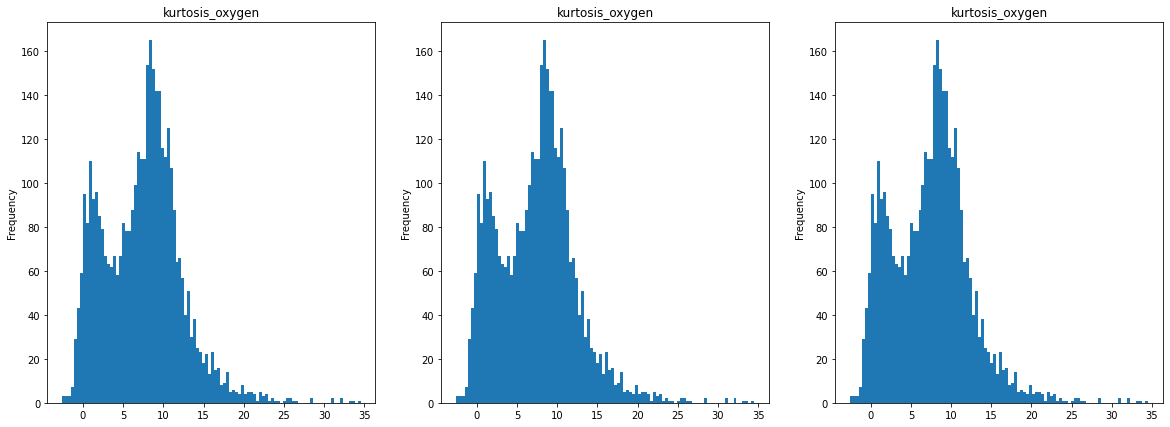

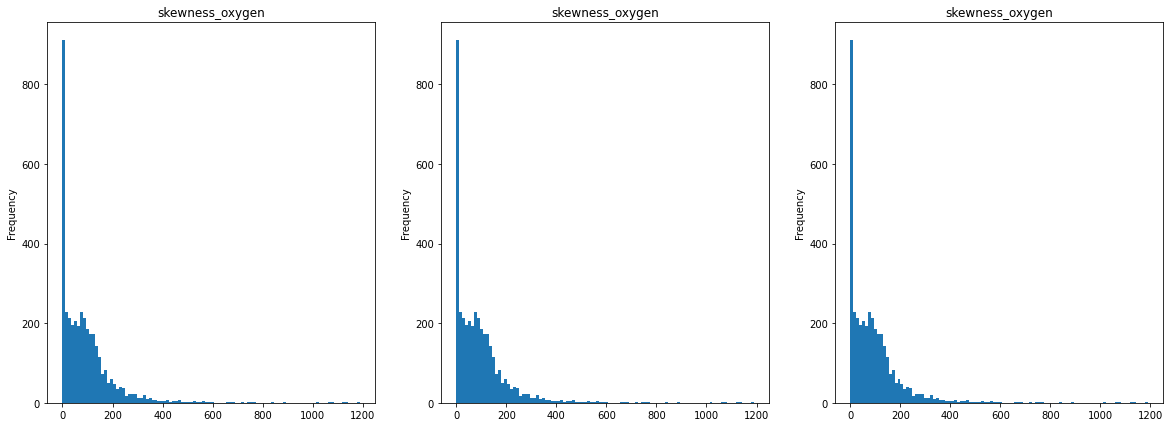

In [21]:
compare_graphs(data_sets, numerical)

Ako z grafou môžeme vidieť, väčšina parametrov je takmer identických. S výnimkou mean_glucose a std_glucose.

In [22]:
# Porovname hodnoty skew na porovnanie jednotlivych metod
print("\t\t\tMean:\t\tQuantile:\tLinear:")
skews = [i.skew() for i in data_sets]
for ind, _ in enumerate(skews[0]):
  for skew in skews:
    if skew is skews[0]:
      print(f'{skew.index[ind]:16} {skew[ind]:16.6f}', end='')
    else:
      print(f"{skew[ind]:16.6f}", end='')
  print()

			Mean:		Quantile:	Linear:
pregnant                 7.003167        7.003167        7.003167
education-num           -0.166170       -0.166184       -0.166170
skewness_glucose         2.882824        2.882354        2.883292
mean_glucose            -0.872948       -0.849093       -1.057674
capital-gain            11.932208       11.932208       11.932208
kurtosis_glucose         2.050426        2.066528        2.047748
fnlwgt                   1.471360        1.471361        1.476135
class                    1.129344        1.129344        1.129344
std_glucose             -0.029405       -0.017034        0.027587
income                   1.269452        1.269452        1.269452
hours-per-week           0.310048        0.313438        0.320765
capital-loss             4.632379        4.632378        4.632380
mean_oxygen              2.620957        2.620957        2.620957
std_oxygen               1.191724        1.191724        1.191724
kurtosis_oxygen          0.611434        0.61143

Po blizsej analyze hodnot skewness je vidno, ze parametre mean_glucose a std_glucose maju najvacsie rozdiely pri implementovanych metodach.

In [23]:
for attr in numerical:
  before = len(integrated_data[attr])
  after = len(integrated_data[integrated_data[attr].notna()])
  percentage = round(((before-after)/before)*100,5)  
  print(attr, percentage, '%')

education-num 0.05199 %
capital-gain 0.0 %
fnlwgt 0.07798 %
hours-per-week 0.07798 %
capital-loss 0.07798 %
skewness_glucose 0.02599 %
mean_glucose 10.08578 %
kurtosis_glucose 0.02599 %
std_glucose 0.05199 %
mean_oxygen 0.0 %
std_oxygen 0.0 %
kurtosis_oxygen 0.0 %
skewness_oxygen 0.0 %


Ak sa pozrieme na zastúpenie prázdnych hodnôt v atribútoch, môžeme vidieť, že mean_glucose ma najviac prázdnych hodnôt. Preto výber metódy doplenenia môže ovplyvniť daľšie použitie tohto parametra. 

Priemer nie je vhodný pretože je najvýraznejšie ovplyvnený vychýlenými hodnotami. Dopĺnanie pomocou kvantilu a lineárnej regresie má podobné výsledky aj keď metoda strednej hodnoty vyzera byt najlepsia alternatíva. 

In [24]:
# nahradi chybajuce ciselne hodnoty strednou hodnotou
for attr in numerical:
  q50 = integrated_data[attr].quantile(0.50)
  integrated_data.fillna(q50, inplace=True)

### Riešenie vychýlených hodnôt

Pri riešení vychýlených hodnôt vyskúšame 2 stratégie. Prvá pozmení dané hodnoty na najbližšíu vhodnú hodnotu, to je buď 5 alebo 95 quantil. Druhá dané hodnoty úplne vynechá

#### Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia

In [25]:
filling_outliers = integrated_data.copy()
# nahradi vychylene hodnoty quantilom
for attr in numerical:
  q_low = filling_outliers[attr].quantile(0.05)
  q_hi = filling_outliers[attr].quantile(0.95)

  filling_outliers[attr] = filling_outliers[attr].clip(lower=q_low, upper=q_hi)

#### Odstránenie vychýlených (odľahlých) pozorovaní

In [26]:
removing_outliers = integrated_data.copy()
# vyhodi vsetky vychylene hodnoty
for attr in numerical:
  removing_outliers = removing_outliers[np.abs(removing_outliers[attr]-removing_outliers[attr].mean())<=(3*removing_outliers[attr].std())]

#### Porovnanie riešení vychýlených hodnôt

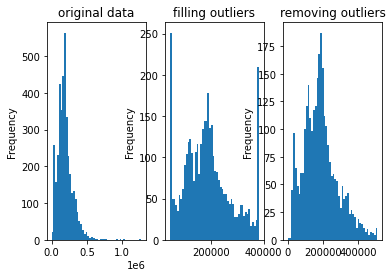

In [27]:
fig, axes = plt.subplots(1, 3)
integrated_data['fnlwgt'].plot.hist(bins=50, title='original data', ax=axes[0])
filling_outliers['fnlwgt'].plot.hist(bins=50, title='filling outliers', ax=axes[1])
removing_outliers['fnlwgt'].plot.hist(bins=50, title='removing outliers', ax=axes[2])
plt.show()

Zobrazili sme si grafy atribúty "fnlwgt". Vidíme, že ak vychýlené hodnoty necháme a následne pozmeníme tak sa nám nakopia na okrajoch, čo nie je želaný výsledok a preto tieto hodnoty odstránime.

In [28]:
# vyhodi vsetky vychylene hodnoty
for attr in numerical:
  integrated_data = integrated_data[np.abs(integrated_data[attr]-integrated_data[attr].mean())<=(3*integrated_data[attr].std())]

### Transformácia atribútu/ov pomocou Power transform

Na numerické atribúty použijeme transformáciu, vďaka ktorej budú dáta bližsie k normálnemu rozloženiu čo by malo zabezpečiť lepšie výsledky pri trénovaní modelu v 3. fáze

In [29]:
# transformnut hodnoty na normalne rozdelenie
pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize= False)
integrated_data[numerical] = pt.fit_transform(integrated_data[numerical])

Ďalej numerické atribúty zoškálujeme na rozpätie medzi 0 a 1 aby mali rovnakú váhu pri trénovaní modelu

In [30]:
# znormalizovat numericke atributy medzi 0 a 1
pt = preprocessing.MinMaxScaler()
integrated_data[numerical] = pt.fit_transform(integrated_data[numerical])

Aby sme vedeli pri trénovaní využiť aj kategorické atribúty tak ich premeníme na vektor. Vznikne nám viac ako 100 riadkov, ktoré ale v ďalšej fáze vyfiltrujeme podľa potreby.

In [31]:
# Slovne atributy premenime na vektory (one-hot encoding)
encoded_data = pd.get_dummies(integrated_data.copy(), columns=categories)

In [32]:
integrated_data.head()

,race,marital-status,occupation,pregnant,education-num,relationship,skewness_glucose,mean_glucose,capital-gain,kurtosis_glucose,...,std_glucose,income,native-country,hours-per-week,capital-loss,workclass,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
0,White,Divorced,Craft-repair,0.0,1.000000,Not-in-family,0.528332,0.477597,0.0,0.825338,...,0.526910,0.0,United-States,0.277242,0.0,private,0.281757,0.138679,0.717684,0.787025
1,White,Divorced,Craft-repair,0.0,0.402641,Not-in-family,0.743526,0.294841,0.0,0.842602,...,0.353754,1.0,United-States,0.529492,0.0,private,0.807613,0.801048,0.273123,0.244021
2,White,Never-married,Other-service,0.0,0.402050,Unmarried,0.614177,0.479362,0.0,0.789313,...,0.409234,0.0,United-States,0.343590,0.0,private,0.546224,0.554319,0.497132,0.494080
3,White,Never-married,Adm-clerical,0.0,0.405024,Not-in-family,0.741070,0.447019,0.0,0.840455,...,0.269364,0.0,United-States,0.652267,0.0,private,0.478556,0.341361,0.520355,0.561634
4,White,Married-civ-spouse,Prof-specialty,0.0,0.402050,Husband,0.427257,0.465706,0.0,0.784739,...,0.776121,1.0,United-States,0.636603,0.0,private,0.461710,0.384251,0.528514,0.554253


Vidíme spracované dáta z druhej časti


## Znovupoužiteľnosť predspracovania (5b).
  - Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav 
  	znovupoužiť na predspracovanie validačnej/testovacej množiny (napr. pomocou funkcie/í) 
  - Očakáva sa aj využitie možnosti `sklearn.pipeline`. 


**Poznamka v zadani:**

  Častým problémom býva využitie informácií, 
ktoré nie sú dostupné v čase zbierania údajov (napr. štatistické informácie o celej testovacej sade 
pri spracovaní trénovacích údajov alebo aj pri spracovaní jednotlivých pozorovaní z testovacej sady), 
čím môžete do trénovania zaniesť znalosť z validačnej alebo testovacej množiny; 
vaše riešenie toto musí ošetrovať.


### Pipeline
Vytvorili sme Integracnu triedu, ktora obsahuje vlastne atributy na definiciu a zoradenie parametrov podla ich vlastnosti. Uzivatel pipeline-y do nej vlozi data cez .fit() a cez .set_params vlozi jednotlive listy nazvov atributov podla ich hodnot, ktore o nich ma. Metódou .transform() získa transformové dáta, ktoré už obsahujú naše predspracovanie. Pomocou atribútov si môže vybrať, ktorú metódu chce aplikovať v ktorej časti spracovania.


In [33]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

class Integration():
  def __init__(self):
    # Rozdelime data do viacerych atributov
    self.irrelevant = []
    self.medical = []
    self.numerical = []
    self.categories = []
    self.booleans = []
    # nastavime default metodu plnenia prazdnych hodnot 
    self.filling_method = 'q50';
    # nastavime default metodu na vychylene hodnoty
    self.anti_bias_method = 'mean'
    # nastavime 
    self.power_method = True
    self.scaling = True

  def _drop_irrelevant(self):
    # vyhodit nepodstatne atributy pre cvicenie modelu
    for attr in self.irrelevant:
      self.integrated_data.drop(columns=attr, inplace=True)
  
  def _drop_categorical(self):
    # vyhodit riadky nenumerickych atributov bez hodnot
    for attr in self.categories:
      self.integrated_data = self.integrated_data[self.integrated_data[attr].notna()]

  def _drop_booleans(self):
    for attr in self.booleans:
      self.integrated_data = self.integrated_data[self.integrated_data[attr].notna()]

  def _replace_mean(self):
    # nahradi chybajuce ciselne hodnoty priemerom
    for attr in numerical:
      mean = self.integrated_data[attr].mean()
      self.integrated_data.fillna(mean, inplace=True)

  def _replace_quantile(self):
    # nahradi chybajuce ciselne hodnoty strednou hodnotou
    for attr in self.numerical:
      q50 = self.integrated_data[attr].quantile(0.50)
      self.integrated_data.fillna(q50, inplace=True)

  def _replace_linear(self):
    for attr in self.numerical:
      self.integrated_data[attr].interpolate(method=self.filling_method, inplace=True, limit_direction="both")

  def _drop_shifted(self):
    # vyhodi vychylene hodnoty
    for attr in self.numerical:
      self.integrated_data = self.integrated_data[np.abs(self.integrated_data[attr]-self.integrated_data[attr].mean())
                           <=(1.5*self.integrated_data[attr].std())]

  def _apply_power_transform(self):
    # transformnut hodnoty na normalne rozdelenie
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize= False)
    self.integrated_data[numerical] = pt.fit_transform(self.integrated_data[numerical])

  def _apply_scaling(self):
    # znormalizovat numericke atributy medzi 0 a 1
    pt = preprocessing.MinMaxScaler()
    self.integrated_data[numerical] = pt.fit_transform(self.integrated_data[numerical])

  def fit(self, x, y=None):
    self.integrated_data = x.copy()
    return self

  def set_params(self, **parameters):
    for parameter, value in parameters.items():
        setattr(self, parameter, value)
    return self

  def transform(self, x, y=None):
    self.integrated_data = x.copy()

    # aplikuje vyhadzovanie dat nad odlisnymi atributmi
    self._drop_irrelevant()
    self._drop_categorical()
    self._drop_booleans()

    # vyplnenie prazdnych hodnot
    if self.filling_method == 'mean':
      self._replace_mean()
    elif self.filling_method == 'q50':
      self._replace_quantile()
    else:
      self._replace_linear()

    self._drop_shifted()

    if self.power_method:
      self._apply_power_transform()

    if self.scaling:
      self._apply_scaling()

    return self.integrated_data


### Testovanie Pipeline
Otestujeme fungovanie pipeline-u na nasich datach.

V rámci testovania si vytvoríme funkciu na extrahovanie údajov z medical_info. Tuto funkciu nezahrnujeme do Pipeline, pretoze je specificka pre nase data.

In [34]:
# Vytvorime nove atributy z medical_info
import json

def get_dict(input_string):
  # konvertuje string na dictionary
  input_string = input_string.replace("'", '"')
  valid_json_string = "[" + input_string + "]" 
  data = json.loads(valid_json_string)[0]
  # convert string values to float
  for i in data:
    data[i] = float(data[i])
  return data

def process_data(data, column):
  # vytvori list asociativnych poli a prekonvertuje hodnoty na float
  list_of_dictionaries = []
  for medical_info in data[column]:
    if isinstance(medical_info, str):
      list_of_dictionaries.append(get_dict(medical_info))
  # konvertujeme list na DataFrame a pridavame ho do povodnych dat
  list_of_dictionaries = pd.DataFrame(list_of_dictionaries)
  data = pd.concat([data, list_of_dictionaries], axis=1, join='inner')
  return data

In [35]:
path_to_data = "../data/"
filename = path_to_data + 'other_train.csv'
other_train = pd.read_csv(filename)
other_train = process_data(other_train, 'medical_info')

In [36]:
pipe = Pipeline(steps=[('integration', Integration())])

# specifikovanie argumentov pre spracovanie dat
args = {
    'integration__irrelevant' : ['name', 'address'],
    'integration__medical' : ['skewness_glucose','mean_glucose','kurtosis_glucose','std_glucose', 'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen'],
    'integration__numerical' : ['education-num','capital-gain', 'fnlwgt','hours-per-week','capital-loss', 'skewness_glucose','mean_glucose','kurtosis_glucose','std_glucose', 'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen'],
    'integration__categories' : ['race','marital-status','occupation','relationship','education','native-country','workclass'],
    'integration__booleans' : ['pregnant','class','income'], 
    'integration__filling_method' : 'q50'
}

pipe.set_params(**args)
pipe.transform(other_train)

,Unnamed: 0,race,marital-status,occupation,pregnant,education-num,relationship,skewness_glucose,mean_glucose,capital-gain,...,income,medical_info,native-country,hours-per-week,capital-loss,workclass,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
2,2,White,Never-married,Other-service,f,0.348334,Unmarried,0.495643,0.542707,0.000000,...,<=50K,"{'mean_oxygen':'3.924749164','std_oxygen':'22....",United-States,0.338788,0.0,Private,0.647222,0.625551,0.390377,0.409972
3,3,White,Never-married,Adm-clerical,f,0.355326,Not-in-family,0.673869,0.483355,0.000000,...,<=50K,"{'mean_oxygen':'3.100334448','std_oxygen':'15....",United-States,0.967965,0.0,Private,0.545344,0.317782,0.436614,0.541639
7,7,White,Married-civ-spouse,Prof-specialty,f,0.348334,Husband,0.662792,0.679222,0.000000,...,<=50K,"{'mean_oxygen':'2.259197324','std_oxygen':'18....",United-States,0.203094,0.0,Private,0.385885,0.469067,0.584793,0.594304
11,11,White,Married-civ-spouse,Sales,f,0.348334,Husband,0.644144,0.433826,0.000000,...,<=50K,"{'mean_oxygen':'4.198996656','std_oxygen':'24....",United-States,0.480403,0.0,Private,0.673715,0.660649,0.328340,0.347439
12,12,White,Divorced,Adm-clerical,f,0.349716,Not-in-family,0.252214,0.537984,1.000000,...,<=50K,"{'mean_oxygen':'4.04180602','std_oxygen':'24.5...",United-States,0.338788,0.0,private,0.658895,0.673644,0.311296,0.315920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,3944,White,Married-civ-spouse,Exec-managerial,F,0.348334,Wife,0.433643,0.589171,0.000000,...,<=50K,"{'mean_oxygen':'5.881270903','std_oxygen':'32....",United-States,0.480403,0.0,private,0.268119,0.334734,0.727121,0.763095
3945,3945,White,Married-civ-spouse,Machine-op-inspct,FALSE,0.348334,Husband,0.498178,0.845250,0.999999,...,<=50K,"{'mean_oxygen':'28.05602007','std_oxygen':'57....",United-States,0.480403,0.0,Private,0.795492,0.817185,0.236478,0.239356
3951,3951,White,Married-civ-spouse,Craft-repair,f,0.349716,Husband,0.561776,0.828201,0.000000,...,>50K,"{'mean_oxygen':'5.099498328','std_oxygen':'27....",United-States,0.480403,0.0,Private,0.970111,0.945275,0.030846,0.041124
3955,3955,White,Never-married,Tech-support,f,0.353913,Not-in-family,0.428844,0.667076,0.000000,...,<=50K,"{'mean_oxygen':'2.982441472','std_oxygen':'19....",United-States,0.394755,0.0,Private,0.967553,0.980997,0.029141,0.026745


## Opätovná realizácia podstatných častí prieskumnej analýzy (5b). 
  - Očakáva sa že dokumentujete zmeny distribúcie hodnôt po realizácii predspracovania 
  - Následne dokumentujete LEN zmeny v prieskumnej analýze 


### Data z analyzy
Pripravíme si dáta v stave, v ktorom sme ich mali v prieskumnej analýze.

In [37]:
from os import listdir
path_to_data = "../data/"
filename = path_to_data + "other_train.csv"
analysis_data = pd.read_csv(filename)

In [38]:
# Upravíme hodnoty na jednoduchy boolean parameter
analysis_data['pregnant'] = analysis_data['pregnant'].replace('TRUE', True)
analysis_data['pregnant'] = analysis_data['pregnant'].replace('T', True)
analysis_data['pregnant'] = analysis_data['pregnant'].replace('t', True)

analysis_data['pregnant'] = analysis_data['pregnant'].replace('FALSE', False)
analysis_data['pregnant'] = analysis_data['pregnant'].replace('F', False)
analysis_data['pregnant'] = analysis_data['pregnant'].replace('f', False)
# dtype stale zostane object, takze ho musime prekonvertovat na bool
analysis_data['pregnant'] = analysis_data['pregnant'].astype('bool') 

# Upravime retazce tak, aby neobsahovali medzery a velke pismena
analysis_data['workclass'] = analysis_data['workclass'].str.strip().str.lower()
analysis_data['class'] = analysis_data['class'].replace(0, False)
analysis_data['class'] = analysis_data['class'].replace(1, True)
# Vyhod vsetky zaznamy obsahujuce N/A
analysis_data = analysis_data.dropna()
# Spracuj udaje z medical_info
analysis_data = process_data(analysis_data, "medical_info")

### Porovnanie prieskumnej analýzy s predspracovaním


In [39]:
comparing_datasets = [analysis_data, integrated_data]

Počas predspracovania sme stratili pár záznamov a vyhodili sme nepotrebné záznamy.

In [40]:
print(comparing_datasets[0].shape) # Faza 1
print(comparing_datasets[1].shape) # Faza 2

(3077, 27)
(2929, 23)


Porovnáme grafy predošlých dát a predspracovaných. Ľavý graf vždy zobrazuje prieskumnú analýzu a pravý predspracované dáta.

				Analysis:								Preprocessing:


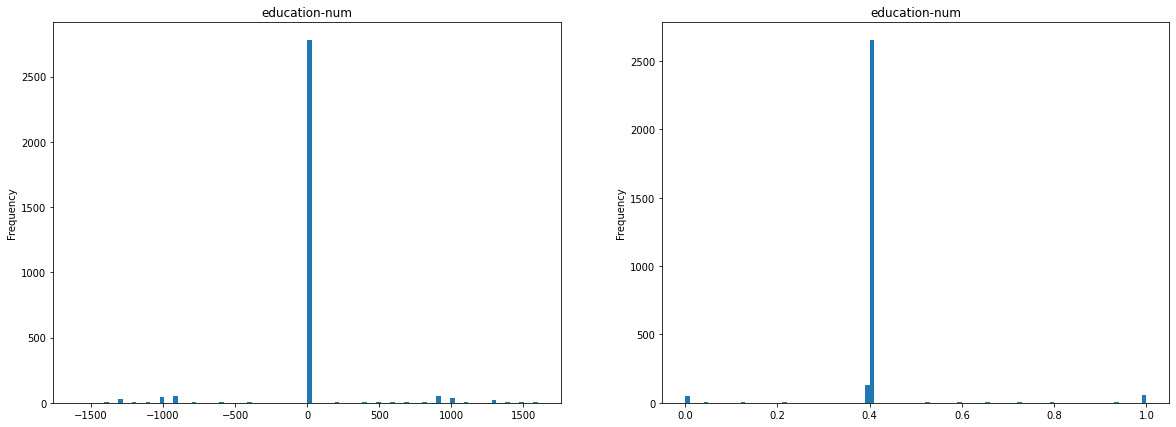

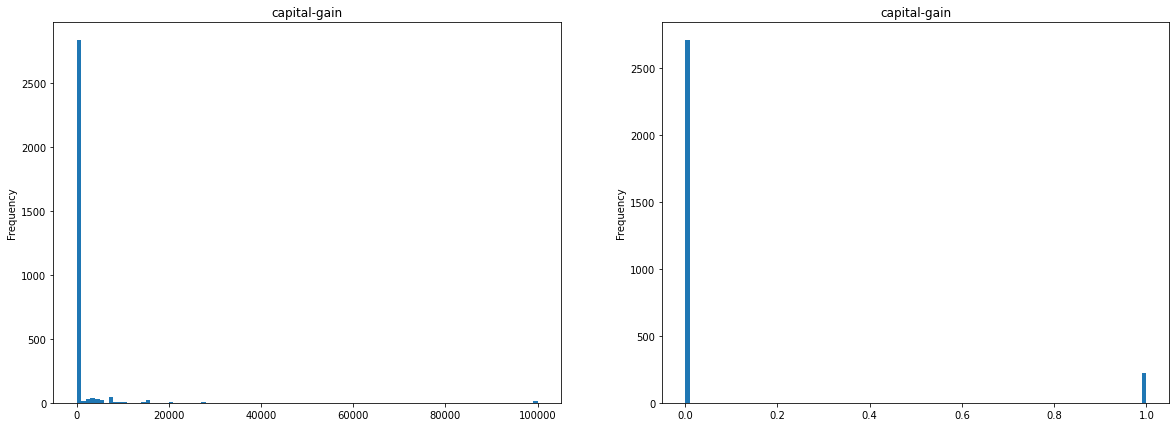

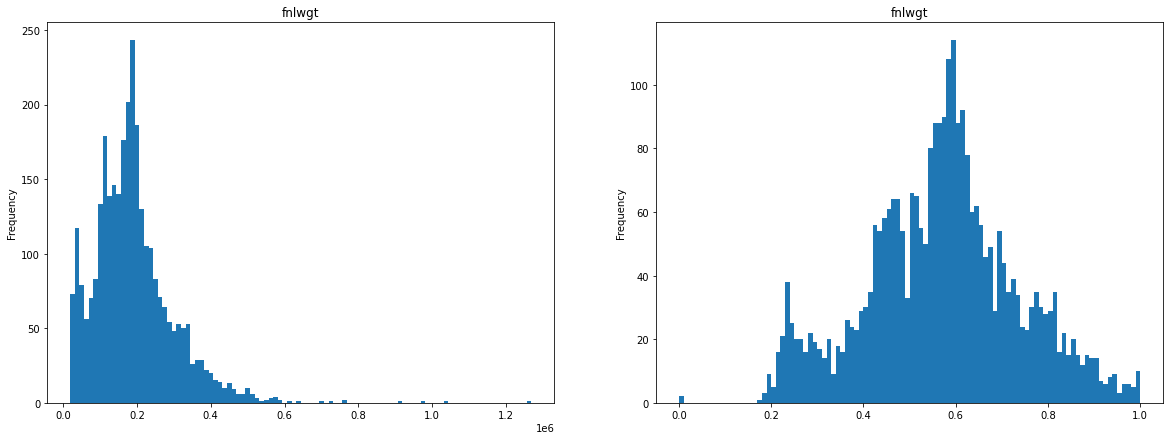

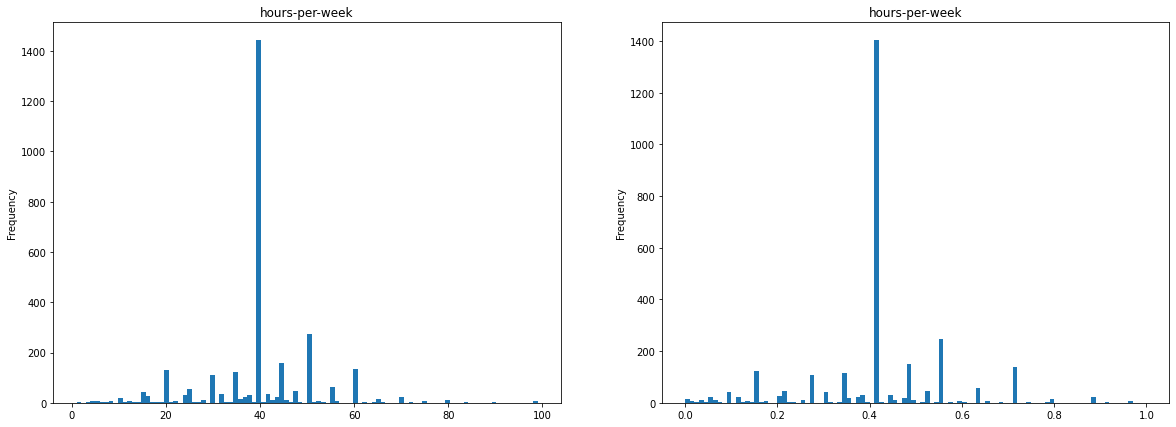

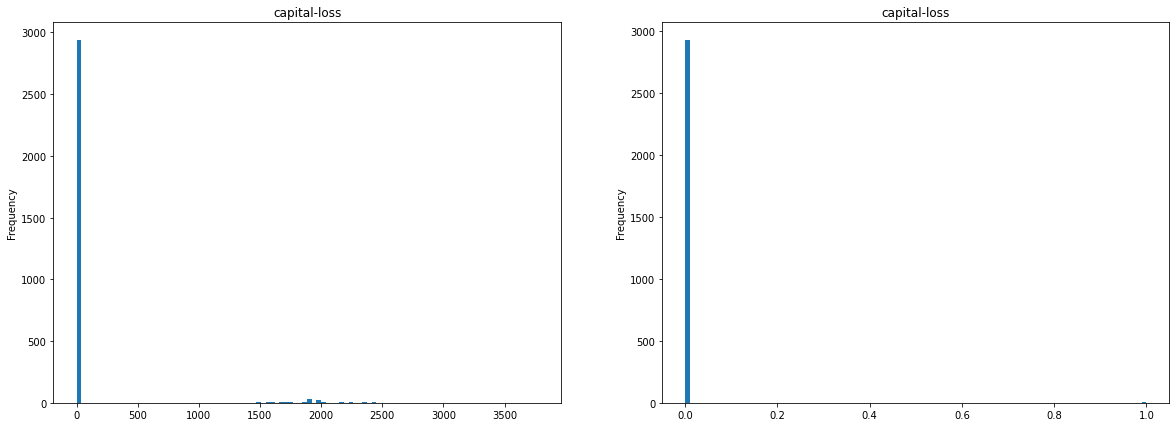

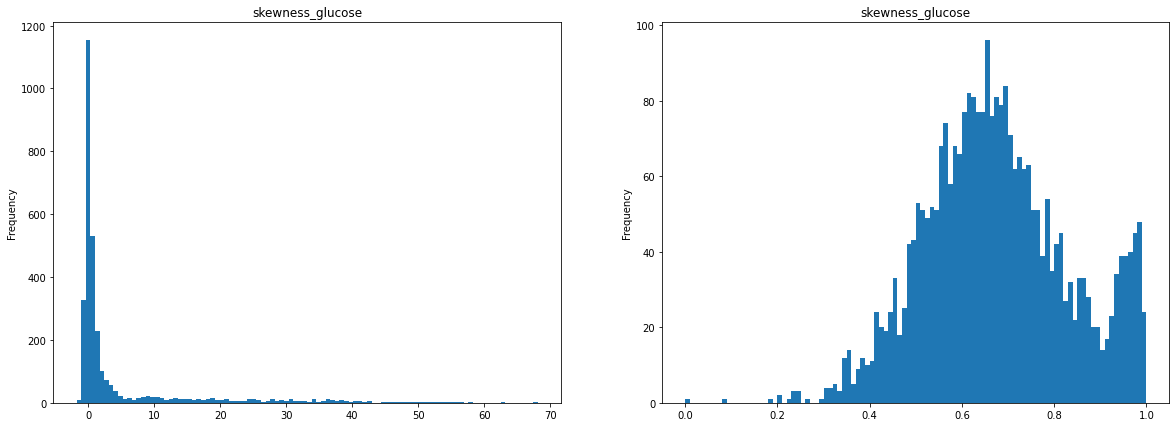

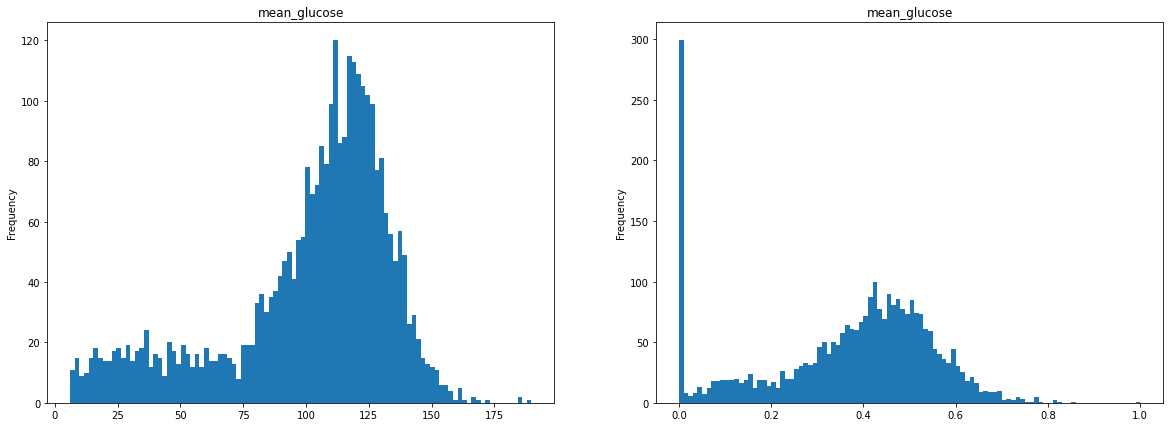

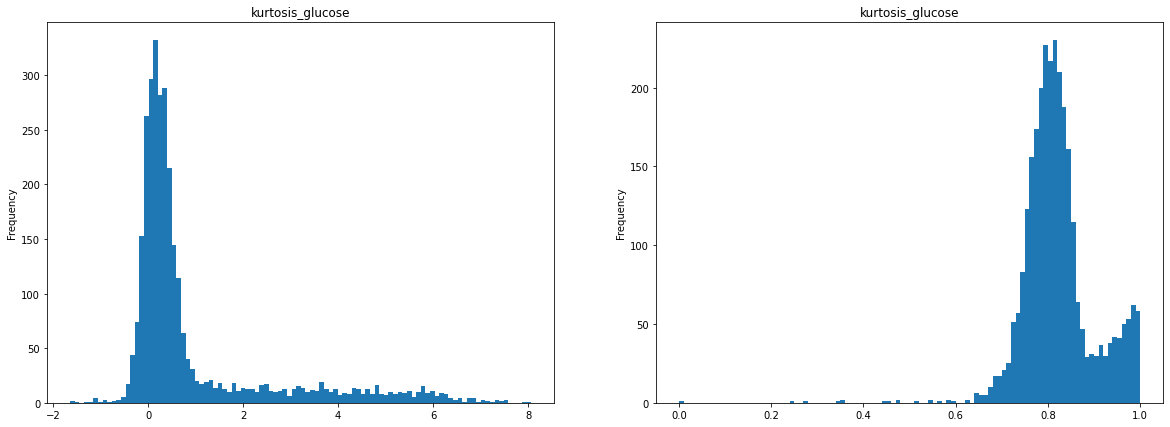

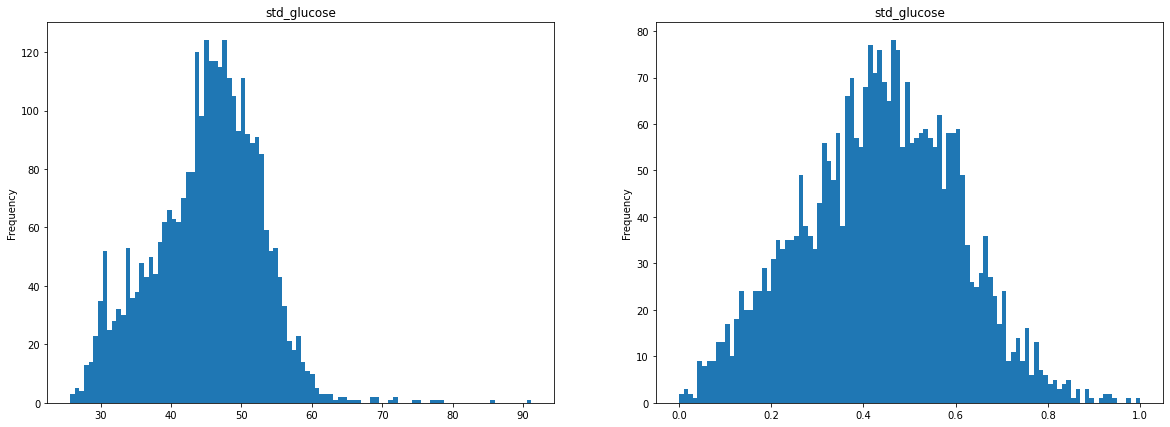

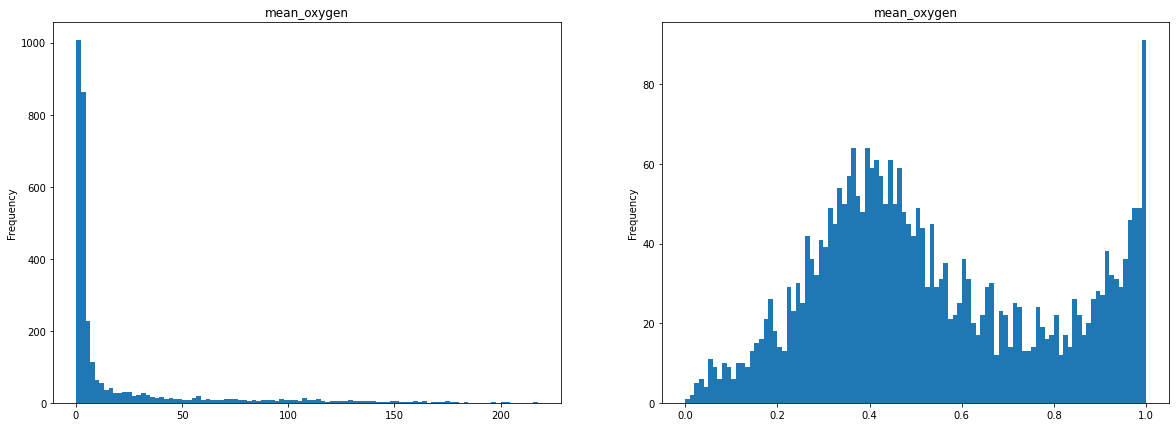

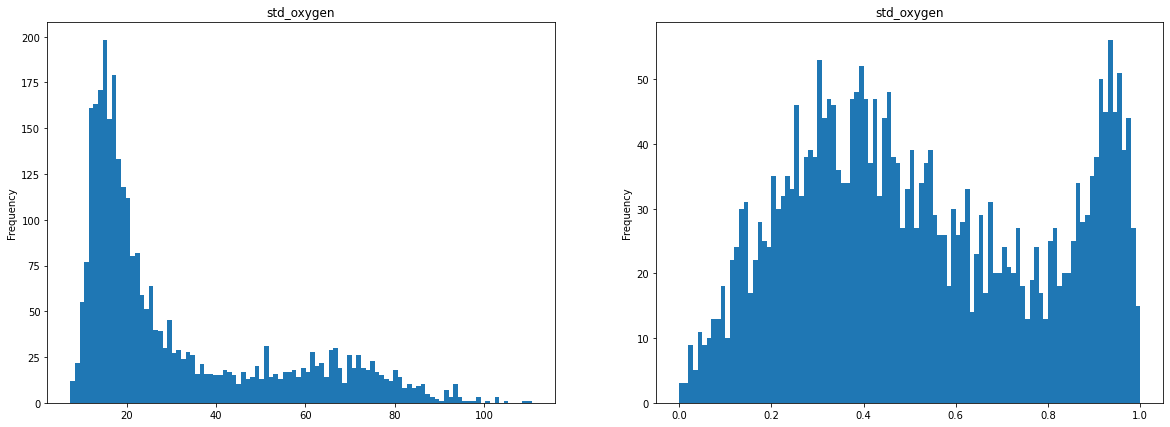

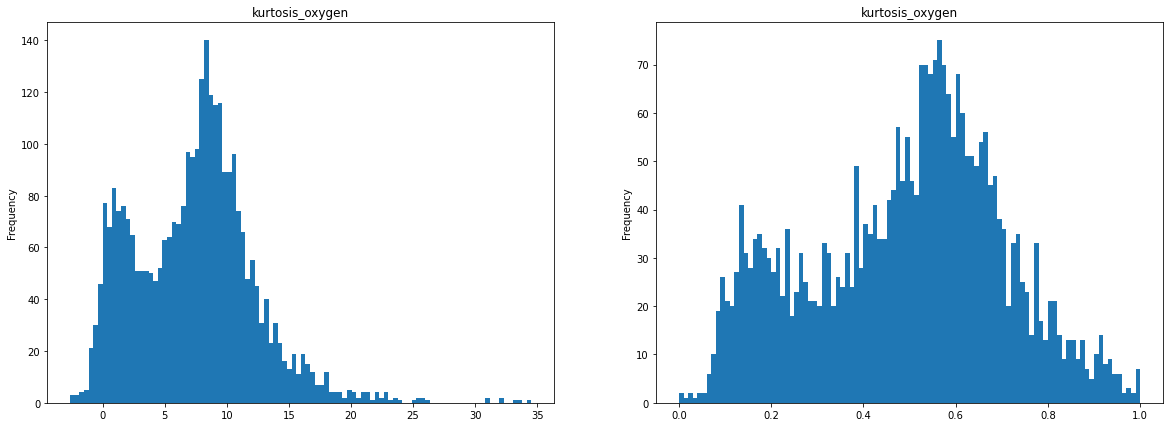

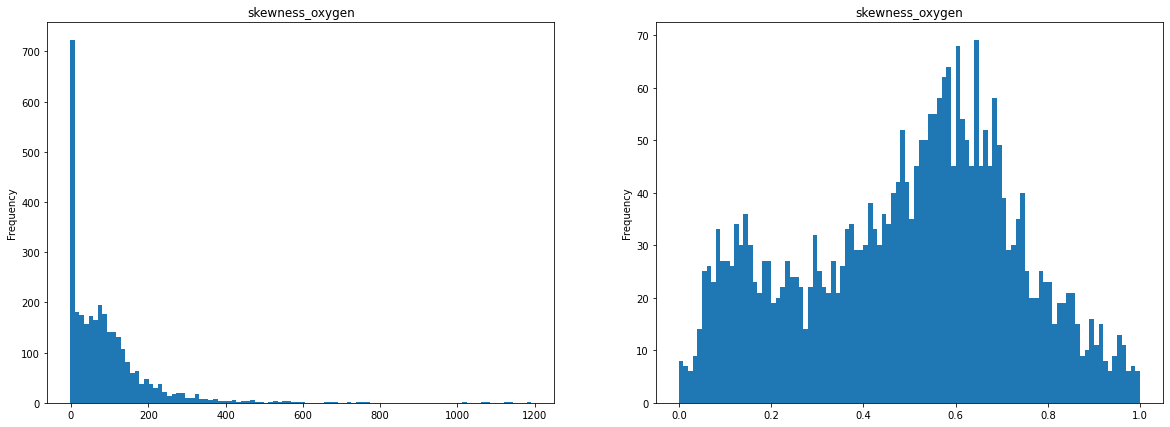

In [41]:
print("\t\t\t\tAnalysis:\t\t\t\t\t\t\t\tPreprocessing:")
compare_graphs(comparing_datasets, numerical)

Z grafou môžeme jasne vidieť, ako sa mnohé atribúty zmenili. Niektoré (napr. std_glucose) sa výrazne posunuli a roztiahli, čím nadobudli formu bližšiu normálovej distribúcií. Zatiaľ čo iné sa úplne zmenili. 

### Parova analyza
Porovname korelacie atributov z prieskumnej analýzy a z predspracovania. 

Heatmapa korelácií z prieskumnej analýzy

<AxesSubplot:>

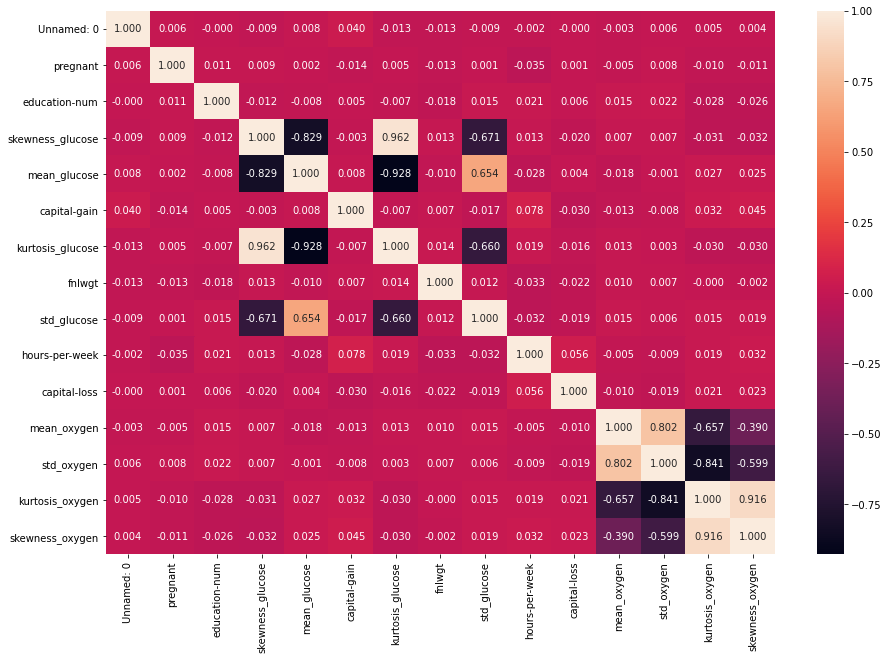

In [42]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(comparing_datasets[0].corr(), ax=ax, annot=True, fmt=".3f")

Heatmapa korelácií z predspracovania

<AxesSubplot:>

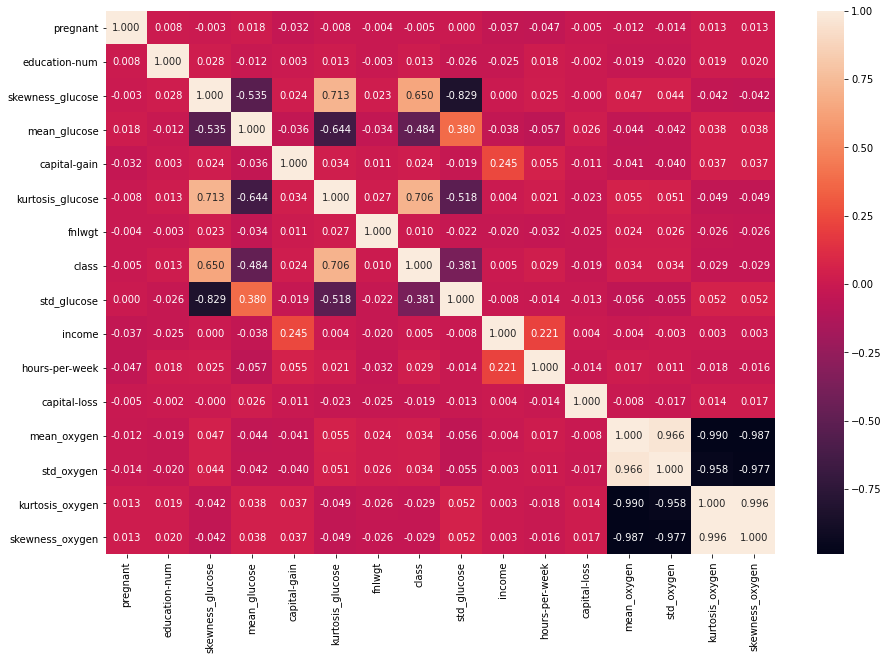

In [43]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(comparing_datasets[1].corr(), ax=ax, annot=True, fmt=".3f")

In [44]:
# Prejdeme vsetky kombinacie a zoberieme vsetky, ktore splnaju podmienku.
def find_correlations(data_set, threashold):
  correlations = data_set.corr()
  correlation_pairs = []
  for param in correlations.columns:
    for i, row in enumerate(correlations[param]):
      if row != 1 and (row >= threashold or row <= -threashold):
        correlation_pairs.append((param, correlations[param].index[i]))

  for pair in correlation_pairs:
    print(f"{pair[0]} <-> {pair[1]}")

In [45]:
print("Analysis:")
find_correlations(comparing_datasets[0], 0.7)
print("\nPreprocessing:")
find_correlations(comparing_datasets[1], 0.7)

Analysis:
skewness_glucose <-> mean_glucose
skewness_glucose <-> kurtosis_glucose
mean_glucose <-> skewness_glucose
mean_glucose <-> kurtosis_glucose
kurtosis_glucose <-> skewness_glucose
kurtosis_glucose <-> mean_glucose
mean_oxygen <-> std_oxygen
std_oxygen <-> mean_oxygen
std_oxygen <-> kurtosis_oxygen
kurtosis_oxygen <-> std_oxygen
kurtosis_oxygen <-> skewness_oxygen
skewness_oxygen <-> kurtosis_oxygen

Preprocessing:
skewness_glucose <-> kurtosis_glucose
skewness_glucose <-> std_glucose
kurtosis_glucose <-> skewness_glucose
kurtosis_glucose <-> class
class <-> kurtosis_glucose
std_glucose <-> skewness_glucose
mean_oxygen <-> std_oxygen
mean_oxygen <-> kurtosis_oxygen
mean_oxygen <-> skewness_oxygen
std_oxygen <-> mean_oxygen
std_oxygen <-> kurtosis_oxygen
std_oxygen <-> skewness_oxygen
kurtosis_oxygen <-> mean_oxygen
kurtosis_oxygen <-> std_oxygen
kurtosis_oxygen <-> skewness_oxygen
skewness_oxygen <-> mean_oxygen
skewness_oxygen <-> std_oxygen
skewness_oxygen <-> kurtosis_oxygen


Ako môžeme vidieť v heatmapach aj vo vypise znacnych korelacii, tak nam stúpol počet korelácií medzi dátami. Zatiaľ čo niektoré kombinácie parametrov medzi sebou stratili spojitosť, iné ich naopak získalo (majú vyššiu korealáciu).